In [80]:
from kshape.core import kshape, zscore

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline

from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_samples, silhouette_score

from time import time

import pandas as pd

import dask.dataframe as dd
from dask.delayed import delayed

import numpy as np
import random

import seaborn
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pickle

import warnings
warnings.filterwarnings("ignore")

import os

In [2]:
time_series = [[1,2,3,4], [0,1,2,3], [0,1,2,3], [1,2,2,3]]

cluster_num = 2
clusters = kshape(zscore(time_series, axis=1), cluster_num)
clusters

[(array([-1.22474487,  0.        ,  0.        ,  1.22474487]), [3]),
 (array([-1.161895  , -0.38729833,  0.38729833,  1.161895  ]), [0, 1, 2])]

In [68]:
df = pd.read_csv('data/sample_jobs_summary.csv', header=[0,1], index_col=[0])
df.rename(columns = {'Unnamed: 9_level_1': 'value'}, level=1, inplace=True)
df

CPU rate           canonical memory usage            \
                mean       std                   mean       std   
job ID                                                            
1358321947  0.002357  0.000687               0.001864  0.000185   
2715734498  0.024608  0.008074               0.006641  0.003526   
3600242317  0.000533  0.000029               0.002885  0.000072   
3996514874  0.037207  0.006681               0.017212  0.001358   
4093289082  0.001579  0.000232               0.000757  0.000020   
...              ...       ...                    ...       ...   
6486215765  0.000336  0.000388               0.000432  0.000505   
6486230048  0.000455  0.000667               0.000251  0.000428   
6486230146  0.000464  0.000549               0.000366  0.000434   
6486431719  0.000154  0.000189               0.001090  0.001128   
6486498163  0.000043  0.000075               0.000000  0.000000   

           local disk space usage           active tasks            \
                             mean       std         mean       std   
job ID                                                               
1358321947               0.000035  0.000007     9.740349  1.498660   
2715734498               0.000031  0.000014     1.000000  0.000000   
3600242317               0.000022  0.000003     1.999641  0.018951   
3996514874               0.000113  0.000016    99.969109  0.499075   
4093289082               0.000028  0.000002     1.000000  0.000000   
...                           ...       ...          ...       ...   
6486215765               0.000000  0.000000     1.000000  0.000000   
6486230048               0.000000  0.000000     4.250000  7.883651   
6486230146               0.000000  0.000000     1.000000  0.000000   
6486431719               0.000000  0.000000     1.000000  0.000000   
6486498163               0.000000  0.000000     1.000000  0.000000   

              job runtime  
                    value  
job ID                     
1358321947  2505600000000  
2715734498  2505600000000  
3600242317  2505600000000  
3996514874  2505600000000  
4093289082   242400000000  
...                   ...  
6486215765      118000000  
6486230048      100000000  
6486230146       98000000  
6486431719      830000000  
6486498163       15000000  

[3265 rows x 9 columns]

In [75]:
scaled = scaler.fit_transform(df['job runtime']['value'].values.reshape(-1,1))

In [76]:
scaled

array([[1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       ...,
       [3.83142068e-05],
       [3.30460034e-04],
       [5.18838217e-06]])

For n_clusters = 3 The average silhouette_score is : 0.9930552317600524


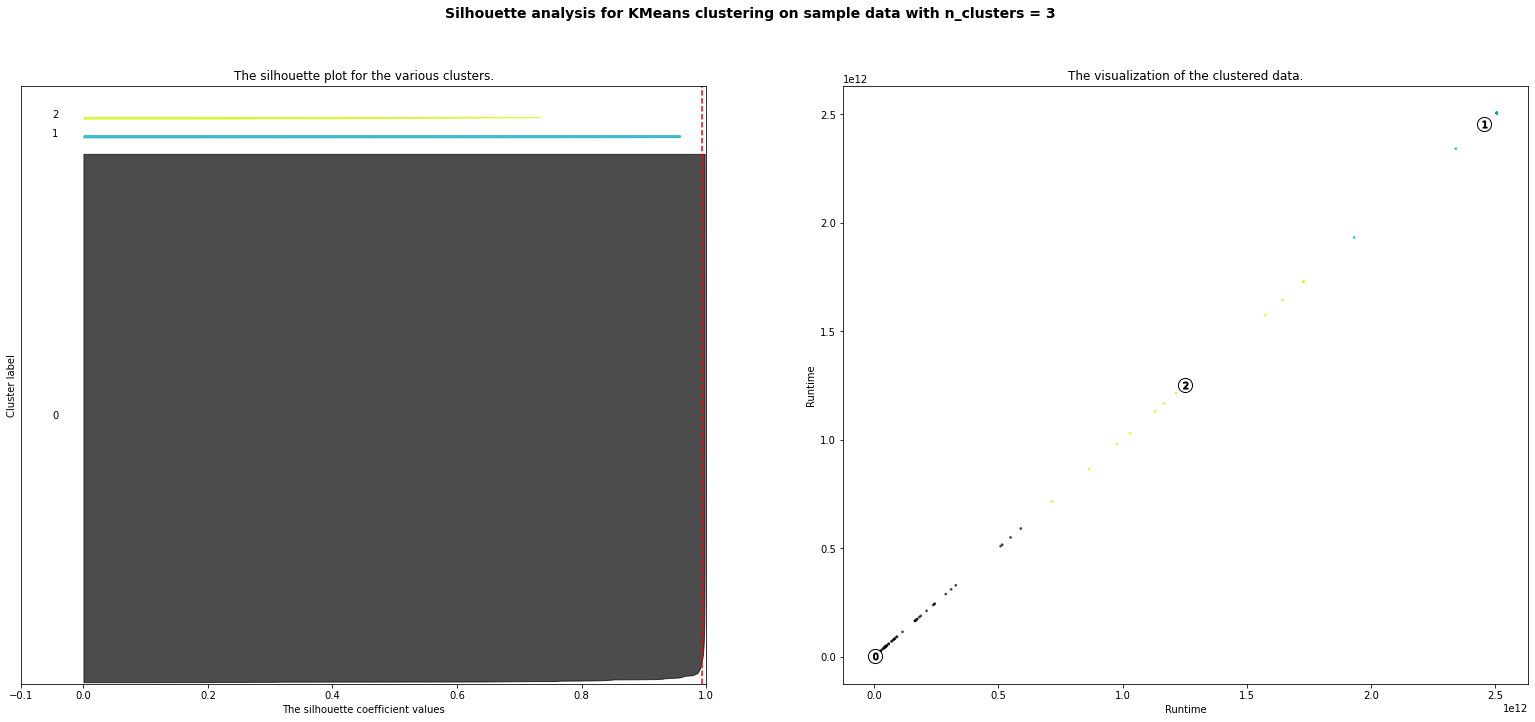

In [142]:
range_n_clusters = [3]

X = df['job runtime']['value'].values.reshape(-1,1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(27, 11)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 100])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init=4)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 100  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 0], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Runtime")
    ax2.set_ylabel("Runtime")


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()



In [106]:
df['cluster results'] = cluster_labels

In [107]:
df[['cluster results', 'job runtime']].groupby('cluster results').agg(['mean', 'std'])

job runtime              
                        value              
                         mean           std
cluster results                            
0                2.861148e+09  2.474391e+10
1                2.456408e+12  1.510939e+11
2                1.252099e+12  3.601898e+11

In [108]:
centers

array([[2.86114819e+09],
       [2.45640787e+12],
       [1.25209918e+12]])

In [17]:
jobs_selection = list(df['job ID'].head(10).values)

In [13]:
data_path = "/data/cloud_data/Google-clusterdata-2011-2/clusterdata-2011-2/"
df_schema = pd.read_csv(os.path.join(data_path, 'schema.csv'))

In [14]:
cols_task_usage = df_schema[df_schema['file pattern'] == 'task_usage/part-?????-of-?????.csv.gz'].content.values
task_usage_files = [os.path.join(data_path, 'task_usage','part-00'+ str(v).zfill(3)+'-of-00500.csv.gz')
                        for v in range(0, 500)]

dfs_task_usage = [delayed(pd.read_csv)(fn, header=None, index_col=False, names=cols_task_usage, delimiter=',') for fn in
           task_usage_files]
readings_task_usage_df = dd.from_delayed(dfs_task_usage)


In [23]:
selected_job_stats = readings_task_usage_df[readings_task_usage_df['job ID'].isin(jobs_selection)][['job ID', 'start time', 'end time', 
                            'CPU rate', 'canonical memory usage', 'local disk space usage']].compute()

In [29]:
selectedJobsTimeSeriesStats = selected_job_stats.groupby(['job ID','end time'])['CPU rate', 'canonical memory usage', 
                                                  'local disk space usage'].agg(['mean', 'std'])

<ipython-input-29-cf8a300e4e3e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  selectedJobsTimeSeriesStats = selected_job_stats.groupby(['job ID','end time'])['CPU rate', 'canonical memory usage',


In [30]:
selectedJobsTimeSeriesStats

CPU rate           canonical memory usage            \
                              mean       std                   mean       std   
job ID     end time                                                             
1358321947 900000000      0.002576  0.000207               0.001808  0.000045   
           1200000000     0.002605  0.000232               0.001803  0.000045   
           1500000000     0.002675  0.000272               0.001814  0.000044   
           1800000000     0.002689  0.000338               0.001802  0.000044   
           2100000000     0.002648  0.000378               0.001803  0.000044   
...                            ...       ...                    ...       ...   
5423595874 2505000000000  0.028493  0.003369               0.027431  0.002887   
           2505300000000  0.025900  0.001701               0.027417  0.002851   
           2505600000000  0.026946  0.002189               0.027348  0.002865   
           2505900000000  0.027811  0.003113               0.027430  0.002821   
           2506200000000  0.028219  0.004991               0.027403  0.002924   

                         local disk space usage                
                                           mean           std  
job ID     end time                                            
1358321947 900000000                   0.000037  5.006940e-07  
           1200000000                  0.000037  4.905779e-07  
           1500000000                  0.000037  4.588936e-07  
           1800000000                  0.000037  4.588936e-07  
           2100000000                  0.000037  4.905779e-07  
...                                         ...           ...  
5423595874 2505000000000               0.000022  1.334309e-05  
           2505300000000               0.000022  1.334309e-05  
           2505600000000               0.000022  1.334309e-05  
           2505900000000               0.000022  1.334309e-05  
           2506200000000               0.000022  1.334309e-05  

[77096 rows x 6 columns]

In [33]:
selectedJobsTimeSeriesStats[('active tasks', 'value')] = selected_job_stats.groupby(['job ID', 'end time'])['end time'].count().values

In [34]:
selectedJobsTimeSeriesStats

CPU rate           canonical memory usage            \
                              mean       std                   mean       std   
job ID     end time                                                             
1358321947 900000000      0.002576  0.000207               0.001808  0.000045   
           1200000000     0.002605  0.000232               0.001803  0.000045   
           1500000000     0.002675  0.000272               0.001814  0.000044   
           1800000000     0.002689  0.000338               0.001802  0.000044   
           2100000000     0.002648  0.000378               0.001803  0.000044   
...                            ...       ...                    ...       ...   
5423595874 2505000000000  0.028493  0.003369               0.027431  0.002887   
           2505300000000  0.025900  0.001701               0.027417  0.002851   
           2505600000000  0.026946  0.002189               0.027348  0.002865   
           2505900000000  0.027811  0.003113               0.027430  0.002821   
           2506200000000  0.028219  0.004991               0.027403  0.002924   

                         local disk space usage               active tasks  
                                           mean           std        value  
job ID     end time                                                         
1358321947 900000000                   0.000037  5.006940e-07           10  
           1200000000                  0.000037  4.905779e-07           10  
           1500000000                  0.000037  4.588936e-07           10  
           1800000000                  0.000037  4.588936e-07           10  
           2100000000                  0.000037  4.905779e-07           10  
...                                         ...           ...          ...  
5423595874 2505000000000               0.000022  1.334309e-05           10  
           2505300000000               0.000022  1.334309e-05           10  
           2505600000000               0.000022  1.334309e-05           10  
           2505900000000               0.000022  1.334309e-05           10  
           2506200000000               0.000022  1.334309e-05           10  

[77096 rows x 7 columns]

In [38]:
set(selectedJobsTimeSeriesStats.index.get_level_values(0))

{1358321947,
 2715734498,
 3600242317,
 3996514874,
 4093289082,
 4537387235,
 4888093099,
 4956349957,
 4974863248,
 5423595874}

# K-MDTSC

In [45]:


def calc_distance(s1, s2):
    
    if(len(s1)==0 or len(s2)==0): return 0
    
    d = 0
    
    for dimension in range(len(s1)):

        for i in range(len(s1[dimension])):
            d += ((s1[dimension][i]-s2[dimension][i])**2)

    d=d**0.5

    return d

def assign_to_clusters(c,s1):
    
    label = -1
    min_dist = 100000000000
    
    for i in range(len(c)):
        ci = c[i]
        tmp_dist = calc_distance(s1, ci)
        if(tmp_dist < min_dist): 
            min_dist = tmp_dist
            label=i
    
    return label

def compute_centroid(points):
   
    if(len(points)==0): return []
    
    centroid = [[0 for i in range(len(points[0][metrics]))] for metrics in range(len(points[0]))]
    
    for point in points:
        for metric in range(len(point)):
            samples = point[metric]
            for i in range(len(samples)):
                centroid[metric][i]+=samples[i]
    
    for metric in range(len(centroid)):
        for i in range(len(centroid[metric])):
            centroid[metric][i]/=len(points)
    
    
    return centroid


def assign_one_point(cluster_points,empty_cluster):
    
    most_popular = 0
    for cluster in cluster_points:
        if(len(cluster_points[cluster])>len(cluster_points[most_popular])):
            most_popular = cluster
            
    farest = -1
    farest_point = 0
    ci = compute_centroid(cluster_points[most_popular])
    for i in range(len(cluster_points[most_popular])):
        s1 = cluster_points[most_popular][i]
        tmp_dist = calc_distance(s1, ci)
        if(tmp_dist>farest):
            farest=tmp_dist
            farest_point = i
    
    
    s1 = cluster_points[most_popular][farest_point]
    cluster_points[empty_cluster].append(s1)
    
    del cluster_points[most_popular][farest_point]
    
    return


def create_clusters(dataset, nclusters):

    current_centroids = random.sample(dataset, nclusters)
    current_distance = -1 

    iterations = 100
    labels = []
    iteration=0
    for iteration in range(iterations):

        cluster_points = {cluster:[] for cluster in range(nclusters)}
        labels = []        
        for s1 in dataset:
            cluster = assign_to_clusters(current_centroids,s1)
            cluster_points[cluster].append(s1)    
            labels.append(cluster)

        for i in range(nclusters):
            if(len(cluster_points[i])==0):
                assign_one_point(cluster_points,i)

        new_centroids = []
        dist = 0 
        for i in range(nclusters):
            centroidi = compute_centroid(cluster_points[i])
            new_centroids.append(centroidi)
            
            dist +=calc_distance(current_centroids[i], new_centroids[i])

        if(dist==0): 
            return labels,new_centroids,cluster_points

        current_distance=dist
        current_centroids = new_centroids
    
    return labels, current_centroids, cluster_points

def run_cluster(dataset,families,attempts,minc,maxc):
        
    Results = {}
    for nclusters in range(minc,maxc):
        Results[nclusters] = []
        for attempt in range(attempts):
            labels,centroids, cluster_points = create_clusters(dataset,nclusters)
            
            SSE = ComputeSSE(dataset,labels,centroids)
            Rand = adjusted_rand_score(labels, [i%families for i in range(len(labels))])
            
            Results[nclusters].append({"labels": labels.copy(),"centroids":centroids.copy(),"SSE":SSE,"RandIndex":Rand})

    return Results

# k-Shape

In [47]:
def denormalize_centroids(dataset,clusters):

    denorm_centroids = {i:[] for i in range(len(clusters))}

    nc = 0
    for cluster in clusters:
        centroid = cluster[0]
        components = {}
        for dimension in range(len(dataset[0])):
            components[dimension] = [[] for _ in range(len(dataset[0][dimension]))]
            
        for pointid in cluster[1]:
            point = dataset[pointid]
            for dimension in range(len(point)):
                samples = point[dimension]
                for i in range(len(samples)):
                    components[dimension][i].append(samples[i])

        for dimension in range(len(dataset[0])):     
            nsamples = len(dataset[0][dimension])
            centroid_dimnension = centroid[dimension*nsamples:(dimension+1)*nsamples].copy()
            for k in range(len(components[dimension])):
                centroid_dimnension[k] = centroid_dimnension[k]*np.std(components[dimension][k])+np.mean(components[dimension][k])
        
            denorm_centroids[nc].append(centroid_dimnension) 
        nc+=1
    return denorm_centroids

def get_labels(dataset_kshape,clusters):
    
    labels = [0 for _ in range(len(dataset_kshape))]
    nc=0
    for cluster in clusters:
        for pointid in cluster[1]: labels[pointid]=nc
        nc+=1
    return labels


In [48]:
def run_k_shape(dataset,families,attempts,minc,maxc):

    dataset_kshape = []
    for p in dataset:
        pg = []
        for i in range(len(p)):
            pg =pg + list(p[i]) 
        dataset_kshape.append(pg)    
        
    Results = {}
    
    for nclusters in range(minc,maxc):
        Results[nclusters]=[]
        for attempt in range(attempts):
            clusters = kshape(dataset_kshape, nclusters)
            centroids = denormalize_centroids(dataset,clusters)
            labels = get_labels(dataset_kshape,clusters)

            SSE = ComputeSSE(dataset,labels,centroids)
            Rand = adjusted_rand_score(labels, [i%families for i in range(len(labels))])

            Results[nclusters].append({"labels": labels.copy(),"centroids":centroids.copy(),"SSE":SSE,"RandIndex":Rand})
                           
    return Results


# Time series

In [54]:
time_series = []
for el in set(selectedJobsTimeSeriesStats.index.get_level_values(0)):
    time_series.append(selectedJobsTimeSeriesStats[selectedJobsTimeSeriesStats.index.get_level_values(0) == el].values)

In [58]:
ResultKMDTSC = run_cluster(time_series,families=2, attempts=10, minc=1, maxc=2)

KeyError: -1

In [133]:
selectedJobsTimeSeriesStatsNaN = \
selectedJobsTimeSeriesStats[~selectedJobsTimeSeriesStats.isin([np.nan, np.inf, -np.inf]).any(1)]
selectedJobsTimeSeriesStatsNaN

CPU rate           canonical memory usage            \
                              mean       std                   mean       std   
job ID     end time                                                             
1358321947 900000000      0.002576  0.000207               0.001808  0.000045   
           1200000000     0.002605  0.000232               0.001803  0.000045   
           1500000000     0.002675  0.000272               0.001814  0.000044   
           1800000000     0.002689  0.000338               0.001802  0.000044   
           2100000000     0.002648  0.000378               0.001803  0.000044   
...                            ...       ...                    ...       ...   
5423595874 2505000000000  0.028493  0.003369               0.027431  0.002887   
           2505300000000  0.025900  0.001701               0.027417  0.002851   
           2505600000000  0.026946  0.002189               0.027348  0.002865   
           2505900000000  0.027811  0.003113               0.027430  0.002821   
           2506200000000  0.028219  0.004991               0.027403  0.002924   

                         local disk space usage               active tasks  
                                           mean           std        value  
job ID     end time                                                         
1358321947 900000000                   0.000037  5.006940e-07           10  
           1200000000                  0.000037  4.905779e-07           10  
           1500000000                  0.000037  4.588936e-07           10  
           1800000000                  0.000037  4.588936e-07           10  
           2100000000                  0.000037  4.905779e-07           10  
...                                         ...           ...          ...  
5423595874 2505000000000               0.000022  1.334309e-05           10  
           2505300000000               0.000022  1.334309e-05           10  
           2505600000000               0.000022  1.334309e-05           10  
           2505900000000               0.000022  1.334309e-05           10  
           2506200000000               0.000022  1.334309e-05           10  

[50121 rows x 7 columns]

In [134]:
selectedJobsTimeSeriesStatsChange = selectedJobsTimeSeriesStatsNaN.copy()

for el in set(selectedJobsTimeSeriesStatsNaN.index.get_level_values(0)):
    selectedJobsTimeSeriesStatsChange[selectedJobsTimeSeriesStatsNaN.index.get_level_values(0) == el] = selectedJobsTimeSeriesStatsNaN[selectedJobsTimeSeriesStatsNaN.index.get_level_values(0) == el].pct_change().values

In [135]:
selectedJobsTimeSeriesStatsChange

CPU rate           canonical memory usage            \
                              mean       std                   mean       std   
job ID     end time                                                             
1358321947 900000000           NaN       NaN                    NaN       NaN   
           1200000000     0.011063  0.121477              -0.002766 -0.002814   
           1500000000     0.026798  0.172264               0.006546 -0.028155   
           1800000000     0.005496  0.245227              -0.006944  0.000035   
           2100000000    -0.015395  0.115489               0.000944  0.012385   
...                            ...       ...                    ...       ...   
5423595874 2505000000000 -0.021935 -0.088842               0.002082  0.017010   
           2505300000000 -0.091005 -0.495238              -0.000510 -0.012399   
           2505600000000  0.040386  0.286988              -0.002517  0.004842   
           2505900000000  0.032101  0.422217               0.002998 -0.015286   
           2506200000000  0.014670  0.603282              -0.000984  0.036531   

                         local disk space usage               active tasks  
                                           mean           std        value  
job ID     end time                                                         
1358321947 900000000                        NaN           NaN          NaN  
           1200000000                 -0.002587 -2.020410e-02          0.0  
           1500000000                 -0.002594 -6.458565e-02          0.0  
           1800000000                  0.000000  4.440892e-16          0.0  
           2100000000                  0.002601  6.904497e-02          0.0  
...                                         ...           ...          ...  
5423595874 2505000000000               0.000000  0.000000e+00          0.0  
           2505300000000               0.000000  0.000000e+00          0.0  
           2505600000000               0.000000  0.000000e+00          0.0  
           2505900000000               0.000000  0.000000e+00          0.0  
           2506200000000               0.000000  0.000000e+00          0.0  

[50121 rows x 7 columns]

In [138]:
selectedJobsTimeSeriesStatsChange = \
selectedJobsTimeSeriesStatsChange[~selectedJobsTimeSeriesStatsChange.isin([np.nan, np.inf, -np.inf]).any(1)]
selectedJobsTimeSeriesStatsChange

CPU rate           canonical memory usage            \
                              mean       std                   mean       std   
job ID     end time                                                             
1358321947 1200000000     0.011063  0.121477              -0.002766 -0.002814   
           1500000000     0.026798  0.172264               0.006546 -0.028155   
           1800000000     0.005496  0.245227              -0.006944  0.000035   
           2100000000    -0.015395  0.115489               0.000944  0.012385   
           2400000000     0.067830 -0.310640              -0.001054  0.050517   
...                            ...       ...                    ...       ...   
5423595874 2505000000000 -0.021935 -0.088842               0.002082  0.017010   
           2505300000000 -0.091005 -0.495238              -0.000510 -0.012399   
           2505600000000  0.040386  0.286988              -0.002517  0.004842   
           2505900000000  0.032101  0.422217               0.002998 -0.015286   
           2506200000000  0.014670  0.603282              -0.000984  0.036531   

                         local disk space usage               active tasks  
                                           mean           std        value  
job ID     end time                                                         
1358321947 1200000000                 -0.002587 -2.020410e-02          0.0  
           1500000000                 -0.002594 -6.458565e-02          0.0  
           1800000000                  0.000000  4.440892e-16          0.0  
           2100000000                  0.002601  6.904497e-02          0.0  
           2400000000                  0.007783 -6.458565e-02          0.0  
...                                         ...           ...          ...  
5423595874 2505000000000               0.000000  0.000000e+00          0.0  
           2505300000000               0.000000  0.000000e+00          0.0  
           2505600000000               0.000000  0.000000e+00          0.0  
           2505900000000               0.000000  0.000000e+00          0.0  
           2506200000000               0.000000  0.000000e+00          0.0  

[39417 rows x 7 columns]

In [139]:
selectedJobsTimeSeriesStatsScaled = selectedJobsTimeSeriesStatsChange.copy()

scaler = MinMaxScaler()

for el in set(selectedJobsTimeSeriesStatsChange.index.get_level_values(0)):
    selectedJobsTimeSeriesStatsScaled[selectedJobsTimeSeriesStatsChange.index.get_level_values(0) == el] = \
        scaler.fit_transform(selectedJobsTimeSeriesStatsChange[selectedJobsTimeSeriesStatsChange.index.get_level_values(0) == el].values)

In [140]:
selectedJobsTimeSeriesStatsScaled

CPU rate           canonical memory usage            \
                              mean       std                   mean       std   
job ID     end time                                                             
1358321947 1200000000     0.168294  0.093437               0.710740  0.053482   
           1500000000     0.170913  0.097668               0.717377  0.052123   
           1800000000     0.167367  0.103747               0.707762  0.053635   
           2100000000     0.163890  0.092938               0.713384  0.054297   
           2400000000     0.177743  0.057435               0.711961  0.056342   
...                            ...       ...                    ...       ...   
5423595874 2505000000000  0.451943  0.080797               0.576755  0.131221   
           2505300000000  0.337777  0.039603               0.564038  0.125745   
           2505600000000  0.554954  0.118892               0.554198  0.128955   
           2505900000000  0.541260  0.132600               0.581248  0.125208   
           2506200000000  0.512448  0.150953               0.561714  0.134855   

                         local disk space usage           active tasks  
                                           mean       std        value  
job ID     end time                                                     
1358321947 1200000000                  0.124677  0.015728     0.172414  
           1500000000                  0.124676  0.015016     0.172414  
           1800000000                  0.125000  0.016053     0.172414  
           2100000000                  0.125325  0.017161     0.172414  
           2400000000                  0.125973  0.015016     0.172414  
...                                         ...       ...          ...  
5423595874 2505000000000               0.840765  0.504925     0.444444  
           2505300000000               0.840765  0.504925     0.444444  
           2505600000000               0.840765  0.504925     0.444444  
           2505900000000               0.840765  0.504925     0.444444  
           2506200000000               0.840765  0.504925     0.444444  

[39417 rows x 7 columns]

In [160]:
selectedJobsTimeSeriesStatsScaledToR = selectedJobsTimeSeriesStatsScaled.copy()

In [161]:
selectedJobsTimeSeriesStatsScaledToR['CPU rate']['mean'] = str(selectedJobsTimeSeriesStatsScaledToR['CPU rate']['mean']).encode('utf-16')
selectedJobsTimeSeriesStatsScaledToR['CPU rate']['std'] = str(selectedJobsTimeSeriesStatsScaledToR['CPU rate']['std']).encode('utf-16')
selectedJobsTimeSeriesStatsScaledToR['canonical memory usage']['mean'] = str(selectedJobsTimeSeriesStatsScaledToR['canonical memory usage']['mean']).encode('utf-16')
selectedJobsTimeSeriesStatsScaledToR['canonical memory usage']['std'] = str(selectedJobsTimeSeriesStatsScaledToR['canonical memory usage']['std']).encode('utf-16')
selectedJobsTimeSeriesStatsScaledToR['local disk space usage']['mean'] = str(selectedJobsTimeSeriesStatsScaledToR['local disk space usage']['mean']).encode('utf-16')
selectedJobsTimeSeriesStatsScaledToR['local disk space usage']['std'] = str(selectedJobsTimeSeriesStatsScaledToR['local disk space usage']['std']).encode('utf-16')
selectedJobsTimeSeriesStatsScaledToR['active tasks']['value'] = str(selectedJobsTimeSeriesStatsScaledToR['active tasks']['value']).encode('utf-16')

In [148]:
import rpy2
from rpy2 import robjects
from rpy2.robjects import pandas2ri

In [162]:
r_data = pandas2ri.py2rpy(selectedJobsTimeSeriesStatsScaledToR)

AttributeError: 'float' object has no attribute 'encode'